<a href="https://colab.research.google.com/github/josephasal/cosmo_inference/blob/tuning%2Brunning/mcmc/tuning_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#Running all the other notebooks to load them in
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/mcmc_algorithm.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/adaptive_sampling_mcmc.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/convergence_diagnostics.ipynb'

#loading in the data from google drive, cleaning and assigning variables
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/LOWZ+ESSENCE+SNLS.csv'
supernova_df = pd.read_csv(filepath)

#defining variables
redshift = supernova_df['Z']
distance_mod = supernova_df['MU']
err_distance_mod = supernova_df['MUERR']

# Adaptive sampling pilot runs for parameter tuning
Need to find the 'best' parameters for my adaptive sampling algorithm.
Ok so last time i did this really inefficiently, doing it a different way this time.

Going to vary the intial step sizes, update intervals, learning rates and measure the acceptance rate, effective sample size (and also check they converge)

Then once a few good ones have been found i will further look into them by looking at the covariance and step history, which i have added to my adaptive mcmc function already

In [4]:
#Define the parameters i want to experiment with
intial_step_sizes = [[0.01, 0.01], [0.02, 0.02], [0.05, 0.05]]  # 3 moderately close step sizes at first
update_intervals = [100, 200, 300] #if you dont know what this is its after how many steps does the adaptive sampling algorithm change the covariance matrix
learning_rates = [0.01, 0.05, 0.1]

#Use itertools to make a grid of combinations
from itertools import product

parameter_grid = list(product(intial_step_sizes, update_intervals, learning_rates))
print('Combinations:', len(parameter_grid)) #the number of different runs is how many different combos there are. Combo made me think of zinmger box meal yummy im hungry




Combinations: 27


In [5]:
%%time


results = [] #empty array to store innit

#Running Adaptive MCMC on all the different combos

#things we keeping fixed
n_steps = 2000
burn_in = 0.2
n_walkers = 10
target_alpha = 0.2
n_walkers = 10

#loop for all values
for (step_size, update_intervals, learning_rates) in parameter_grid:

  #10 initial guesses in the ranges of 0.2<omega_m<0.4 and 0.6<h<0.8
  initial_guess = [[np.random.uniform(0.2,0.4), np.random.uniform(0.6,0.8)]
                for _ in range(n_walkers)]
  #calling the adaptive mcmc function
  samples, avg_alpha, cov_hist, step_hist = adaptive_metropolis_hastings(log_likelihood,
                                                                         redshift,
                                                                         distance_mod,
                                                                         err_distance_mod,
                                                                         n_steps,
                                                                         initial_guess, step_size,
                                                                         burn_in, n_walkers, update_intervals, target_alpha, learning_rates)


  #Calculate ess for the combination we are on for both omega m and h, using the ess function defined in the convergence diagnostics file
  ess_omega = eff_sample_size_multichain(samples[:,:,0])
  ess_h = eff_sample_size_multichain(samples[:,:,1])

  #store all of this shit in a dictionary
  results.append({ 'samples': samples,
      'step_size': step_size, 'update_interval': update_intervals,
      'learning_rate': learning_rates, 'avg_alpha': avg_alpha,
    'ess_omega': ess_omega, 'ess_h': ess_h, 'cov_hist': cov_hist, 'step_hist': step_hist
  })


After 100 iteration alpha = 0.353, new step size = [0.031699370924825915, 0.027755172705268675]
After 200 iteration alpha = 0.073, new step size = [0.03393590259381697, 0.02490361422930096]
After 300 iteration alpha = 0.076, new step size = [0.032232947380060765, 0.022311846805686576]
After 400 iteration alpha = 0.084, new step size = [0.030667709822574152, 0.019998048181977986]
After 500 iteration alpha = 0.095, new step size = [0.02928132883416935, 0.01794198630536205]
After 600 iteration alpha = 0.13, new step size = [0.028668399728630136, 0.016114689750639195]
After 700 iteration alpha = 0.11599999999999999, new step size = [0.027446794335021236, 0.014465668221081451]
After 800 iteration alpha = 0.15, new step size = [0.02659801710948764, 0.012995960698589964]
After 900 iteration alpha = 0.158, new step size = [0.025823636990579137, 0.011699627823567765]
After 1000 iteration alpha = 0.168, new step size = [0.025156192817300676, 0.010532315290091047]
After 1100 iteration alpha = 0.2

In [10]:
#took 30 mins to do all these pilots

#converting dictionary to dataframe
results_df = pd.DataFrame(results)


#gonna save to a file so i dont have to run that again and can save the data
#have to save as pickle file because step and cov history are arrays
results_df.to_pickle("adaptive_mcmc_results_final.pkl")

In [3]:
#loading in the csv with the results of the pilot run
filepath = '/content/drive/MyDrive/Colab Notebooks/Bayesian Stats in Cosmology/Actual project code/adaptive_mcmc_results_final.pkl'
results_df = pd.read_pickle(filepath)

results_df.head()

,samples,step_size,update_interval,learning_rate,avg_alpha,ess_omega,ess_h,cov_hist,step_hist
0,"[[[0.2306767742744887, 0.8392076166488608], [0...","[0.01, 0.01]",100,0.01,0.21430,826.983913,1243.081831,"[[[0.0010048501170296987, 6.0793481165027735e-...","[[0.031699370924825915, 0.027755172705268675],..."
1,"[[[0.27801906236439755, 0.8392151620352181], [...","[0.01, 0.01]",100,0.05,0.21970,609.504196,1053.242873,"[[[0.00048561392615275586, -5.1106759863723844...","[[0.02203664961269648, 0.02692653628454946], [..."
2,"[[[0.2596878880533835, 0.8399694670997712], [0...","[0.01, 0.01]",100,0.10,0.23985,969.765167,1399.299697,"[[[0.000994986277326035, -0.000101809989358697...","[[0.031543403071419465, 0.022429109706671706],..."
3,"[[[0.3097551318196611, 0.8358143962658081], [0...","[0.01, 0.01]",200,0.01,0.19765,559.811637,1050.889509,"[[[0.00037011938097581125, -8.465209688009402e...","[[0.019238486972103893, 0.017757904049142667],..."
4,"[[[0.25129025579102104, 0.8404683779760646], [...","[0.01, 0.01]",200,0.05,0.18255,451.576560,870.936677,"[[[0.00044329524086354175, -7.481227353657791e...","[[0.021054577670035126, 0.02055528979589626], ..."


# Analysing Pilot runs
Plotting average acceptance rate and ESS for each parameter

In [5]:
!pip install SciencePlots

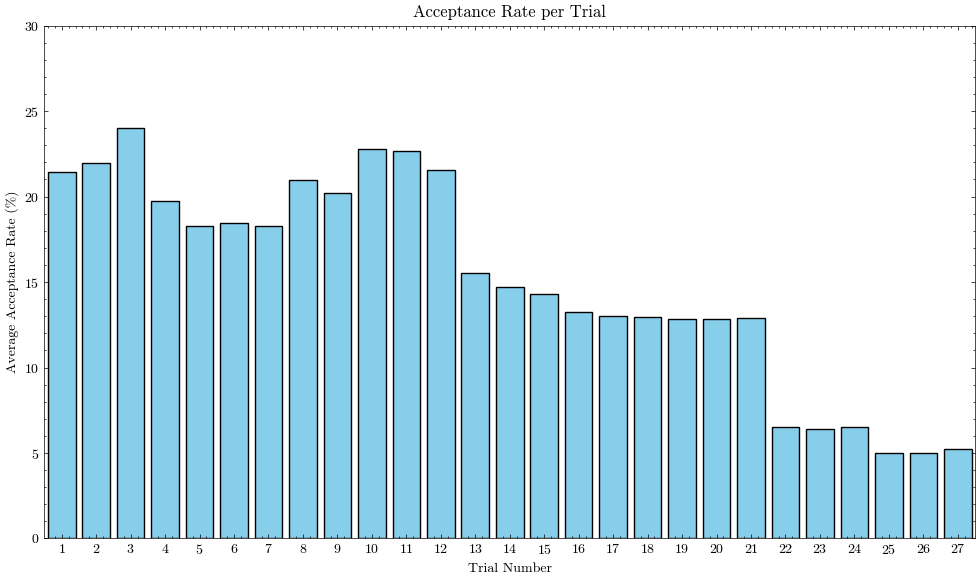

In [6]:
import scienceplots


#append df to have number of the trial to keep track
results_df['trial'] = np.arange(1, len(results_df) +1)


plt.style.use(['science', 'no-latex'])

plt.figure(figsize=(10,6))
plt.bar(results_df['trial'], results_df['avg_alpha']*100,
        width=0.8, color='skyblue', edgecolor='black')
plt.ylim(0,30)
plt.xlim([0.5,len(results_df)+0.5])
plt.xlabel('Trial Number')
plt.ylabel('Average Acceptance Rate (%)')
plt.title('Acceptance Rate per Trial')
plt.xticks(np.linspace(1,27,27))



plt.tight_layout()

plt.show()


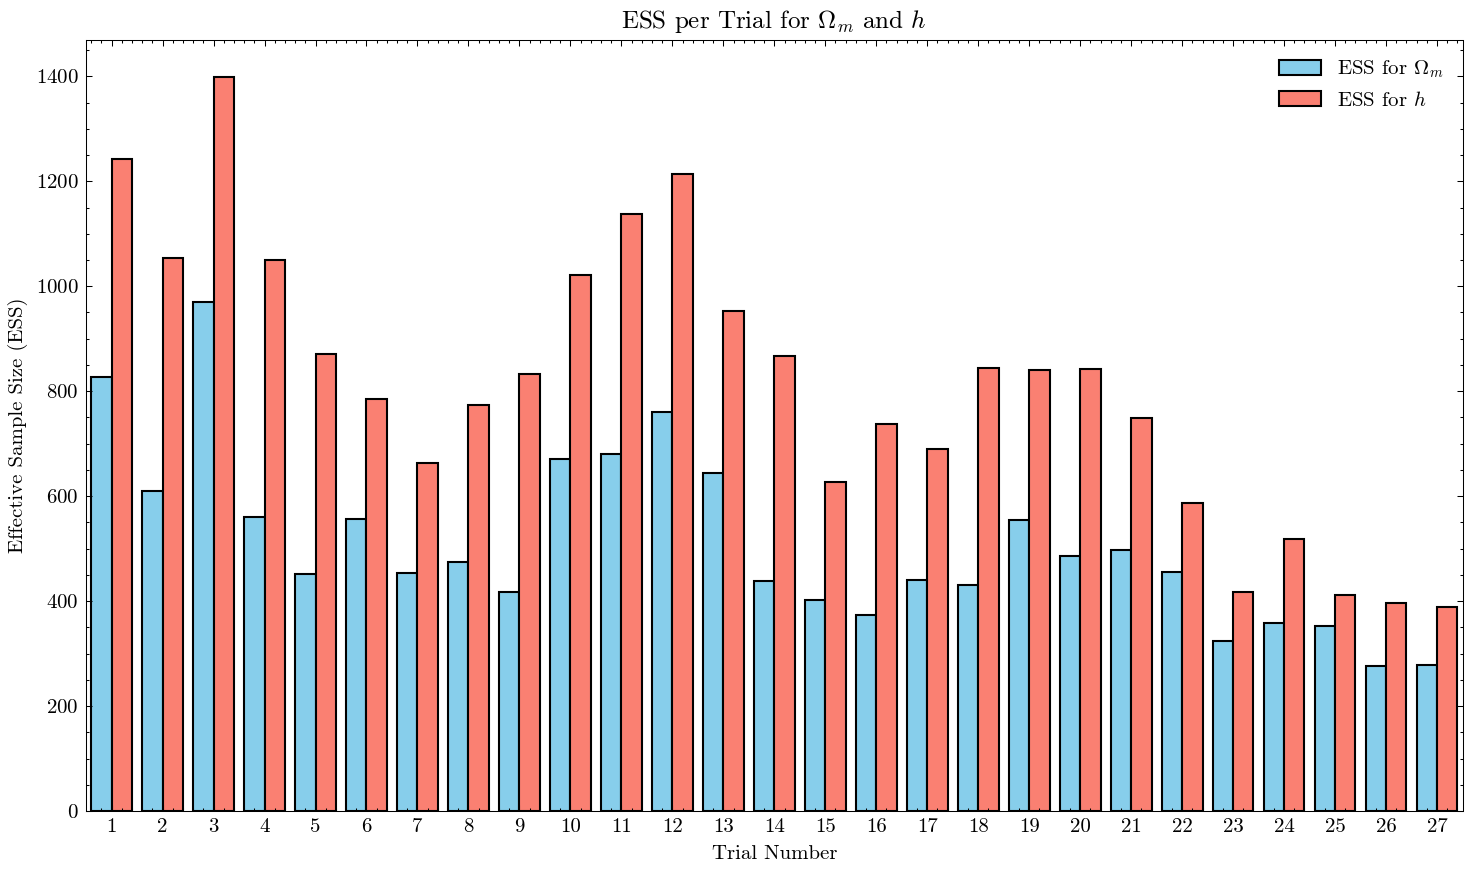

In [7]:
#plot for ess for omega m and h

plt.style.use(['science', 'no-latex'])
n_trials = len(results_df)

plt.figure(figsize=(10,6), dpi=150)

width = 0.4

# Use the trial column as the baseline x positions:
x_positions = results_df['trial']

# Plot bars for ESS of omega_m (shifted left by width/2)
plt.bar(x_positions - width/2, results_df['ess_omega'],
        width=width, color='skyblue', edgecolor='black',
        label='ESS for $\\Omega_m$')

# Plot bars for ESS of h (shifted right by width/2)
plt.bar(x_positions + width/2, results_df['ess_h'],
        width=width, color='salmon', edgecolor='black',
        label='ESS for $h$')

plt.xlim([0.5, n_trials + 0.5])


plt.xticks(x_positions, x_positions)

plt.xlabel("Trial Number")
plt.ylabel("Effective Sample Size (ESS)")
plt.title("ESS per Trial for $\\Omega_m$ and $h$")


plt.legend()

plt.tight_layout()
plt.show()


Plotting step size history of each

* Best looking Trials are: 1, 3, 10
* Make sure they converged using GR diagnostic
* Find out what they used
* Plotting the covariances and step sizes

In [8]:
#Getting stats for each
trial_1 = results_df.iloc[0]
trial_3 = results_df.iloc[2]
trial_10 = results_df.iloc[9]

for i in [0, 2, 9]:
    row = results_df.iloc[i]
    print(f"Trial {row['trial']}:")
    print(f"Step Size: {row['step_size']}")
    print(f"Update Interval: {row['update_interval']}")
    print(f"Learning Rate: {row['learning_rate']}")
    print(f"Average Acceptance Rate (avg_alpha): {row['avg_alpha']:.4f}")
    print(f"ESS for Omega_m: {row['ess_omega']:.2f}")
    print(f"ESS for h: {row['ess_h']:.2f}")


Trial 1:
Step Size: [0.01, 0.01]
Update Interval: 100
Learning Rate: 0.01
Average Acceptance Rate (avg_alpha): 0.2143
ESS for Omega_m: 826.98
ESS for h: 1243.08
Trial 3:
Step Size: [0.01, 0.01]
Update Interval: 100
Learning Rate: 0.1
Average Acceptance Rate (avg_alpha): 0.2398
ESS for Omega_m: 969.77
ESS for h: 1399.30
Trial 10:
Step Size: [0.02, 0.02]
Update Interval: 100
Learning Rate: 0.01
Average Acceptance Rate (avg_alpha): 0.2278
ESS for Omega_m: 670.35
ESS for h: 1021.52


In [13]:
#Gelman rubin to check the 3 chains have converged
trial1_chain = np.array(results_df.iloc[0,0])
trial3_chain = np.array(results_df.iloc[2,0])
trial10_chain = np.array(results_df.iloc[9,0])

#loop this for the trials i want

for i in [0,2,9]:

  ith_chain = np.array(results_df.iloc[i,0])

  #pick omega and h chains
  ith_omega = ith_chain[:,:,0]
  ith_h = ith_chain[:,:,1]

  #calculate GR for omega and h
  gr_omega = gelman_rubin(ith_omega)
  gr_h = gelman_rubin(ith_h)

  print(f'For trial {i+1}: the GR values for omega = {gr_omega}, h = {gr_h}')



For trial 1: the GR values for omega = 1.0092516366555275, h = 1.0041358904043578
For trial 3: the GR values for omega = 1.0078928146191224, h = 1.0034093872056968
For trial 10: the GR values for omega = 1.0014918451966417, h = 1.0035414934679603


Plotting step history

In [14]:
#getting step history from the table

step_hist1 = np.array(results_df.iloc[0]['step_hist'])
step_hist3 = np.array(results_df.iloc[2]['step_hist'])
step_hist10 = np.array(results_df.iloc[9]['step_hist'])

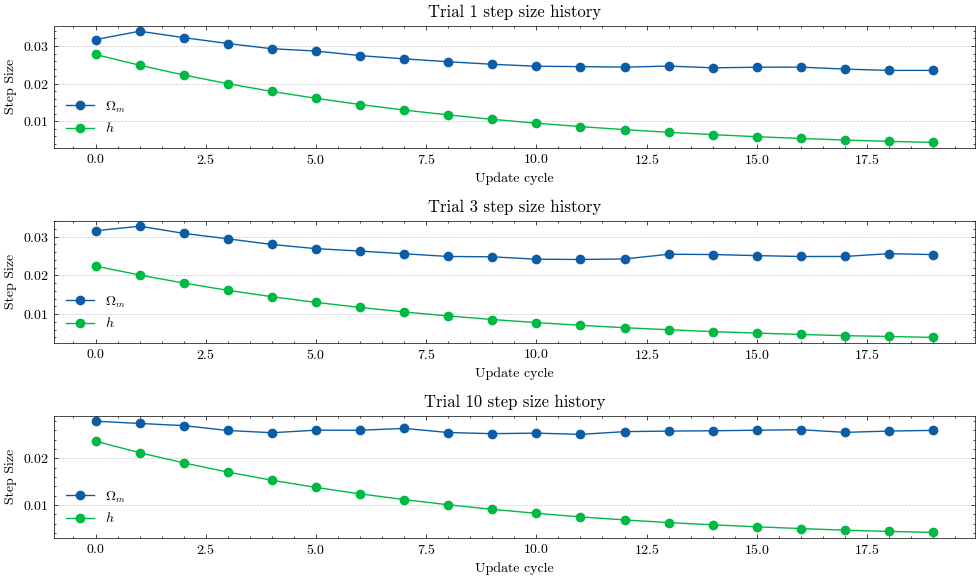

In [15]:
#subplot of all the things

plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.plot(step_hist1[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist1[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 1 step size history')
plt.legend()

plt.subplot(3,1,2)
plt.plot(step_hist3[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist3[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 3 step size history')
plt.legend()


plt.subplot(3,1,3)
plt.plot(step_hist10[:,0], label = '$\Omega_m$', marker='o')
plt.plot(step_hist10[:,1], label = '$h$', marker='o')
plt.xlabel('Update cycle')
plt.ylabel('Step Size')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Trial 10 step size history')
plt.legend()

plt.tight_layout()
plt.show()

#in retrospect i shouldve for looped that mayeb

Step size history is looking normal for all so i will proceed with trial 3 paramaters of 0.01 step size, 100 update interval, 0.1 LR